In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

print(f"Torch version: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Torch version: 2.9.1+cu128
Device: cpu


In [3]:
class Expert(nn.Module):
    """Standard expert (FFN)"""
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff, bias=False)
        self.w2 = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        hidden = F.gelu(self.w1(x))
        hidden = self.dropout(hidden)
        output = self.w2(hidden)
        return self.dropout(output)

print("✓ Expert module ready")

✓ Expert module ready


In [4]:
class DeepSeekMoERouter(nn.Module):
    """
    DeepSeek MoE Router
    
    Key Innovation: Shared + Routed Experts
    
    Traditional MoE:
    - All experts are "routed" (selected dynamically)
    - Can lead to expert underutilization
    
    DeepSeek MoE:
    - Shared experts: ALWAYS activated for every token
    - Routed experts: Dynamically selected (Top-K)
    - Output = Shared + Routed
    
    Benefits:
    ✓ Shared experts learn common knowledge
    ✓ Routed experts specialize
    ✓ More parameter efficient
    ✓ Better expert utilization
    
    Example (2 shared + 4 routed, K=2):
    Token → Shared Expert 0 + Shared Expert 1 + 
            Top-2 from [Routed 0, Routed 1, Routed 2, Routed 3]
    """
    def __init__(self, d_model, num_routed_experts, top_k=2):
        super().__init__()
        
        self.num_routed_experts = num_routed_experts
        self.top_k = top_k
        
        # Router only for routed experts
        self.gate = nn.Linear(d_model, num_routed_experts, bias=False)
        
    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model]
            
        Returns:
            top_k_indices: [batch, seq_len, top_k]
            top_k_weights: [batch, seq_len, top_k]
            router_probs: [batch, seq_len, num_routed_experts]
        """
        batch_size, seq_len, d_model = x.shape
        
        # Compute router logits for routed experts only
        router_logits = self.gate(x)  # [batch, seq_len, num_routed_experts]
        
        # Get top-k routed experts
        top_k_logits, top_k_indices = torch.topk(
            router_logits,
            k=self.top_k,
            dim=-1
        )
        
        # Normalize weights
        top_k_weights = F.softmax(top_k_logits, dim=-1)
        
        # Full probabilities
        router_probs = F.softmax(router_logits, dim=-1)
        
        return top_k_indices, top_k_weights, router_probs

# Test Router
num_routed_experts = 6
top_k = 2
router = DeepSeekMoERouter(d_model=512, num_routed_experts=num_routed_experts, top_k=top_k)

x = torch.randn(2, 10, 512)
top_k_indices, top_k_weights, router_probs = router(x)

print(f"Routed experts: {num_routed_experts}")
print(f"Top-K: {top_k}")
print(f"Router output shapes:")
print(f"  Top-K indices: {top_k_indices.shape}")
print(f"  Top-K weights: {top_k_weights.shape}")
print(f"✓ DeepSeek Router working!")

Routed experts: 6
Top-K: 2
Router output shapes:
  Top-K indices: torch.Size([2, 10, 2])
  Top-K weights: torch.Size([2, 10, 2])
✓ DeepSeek Router working!


In [5]:
class DeepSeekMoELayer(nn.Module):
    """
    DeepSeek MoE Layer
    
    Architecture Innovation:
    ┌─────────────────┐
    │  Input Token    │
    └────────┬────────┘
             │
        ┌────┴─────┐
        │          │
    ┌───▼───┐  ┌──▼─────────────┐
    │Shared │  │   Router       │
    │Experts│  │  (Top-K from   │
    │       │  │   Routed)      │
    └───┬───┘  └──┬─────────────┘
        │         │
        │    ┌────▼─────┐
        │    │  Routed  │
        │    │  Experts │
        │    └────┬─────┘
        │         │
        └────┬────┘
             │
    ┌────────▼────────┐
    │ Combined Output │
    └─────────────────┘
    
    DeepSeek-V2 uses:
    - 2 shared experts (always active)
    - 64 routed experts (top-6 selected)
    - This achieves competitive performance with only 21B activated params
      from 236B total params
    """
    def __init__(
        self,
        d_model=512,
        d_ff=2048,
        num_shared_experts=2,
        num_routed_experts=6,
        top_k=2,
        dropout=0.1
    ):
        super().__init__()
        
        self.d_model = d_model
        self.num_shared_experts = num_shared_experts
        self.num_routed_experts = num_routed_experts
        self.top_k = top_k
        
        # Shared experts (always activated)
        self.shared_experts = nn.ModuleList([
            Expert(d_model, d_ff, dropout) for _ in range(num_shared_experts)
        ])
        
        # Routed experts (top-k selection)
        self.routed_experts = nn.ModuleList([
            Expert(d_model, d_ff, dropout) for _ in range(num_routed_experts)
        ])
        
        # Router (only for routed experts)
        self.router = DeepSeekMoERouter(d_model, num_routed_experts, top_k)
        
        # Optional: different scaling for shared vs routed
        self.shared_scale = 1.0 / num_shared_experts
        self.routed_scale = 1.0
        
    def forward(self, x, return_router_info=False):
        """
        Args:
            x: [batch, seq_len, d_model]
            
        Returns:
            output: [batch, seq_len, d_model]
            (optional) router_info: dict with routing details
        """
        batch_size, seq_len, d_model = x.shape
        
        # === Shared Expert Path (ALWAYS active) ===
        shared_output = torch.zeros_like(x)
        for expert in self.shared_experts:
            shared_output += expert(x) * self.shared_scale
        
        # === Routed Expert Path (Top-K selection) ===
        
        # Route tokens
        top_k_indices, top_k_weights, router_probs = self.router(x)
        
        # Flatten for processing
        x_flat = x.view(-1, d_model)
        top_k_indices_flat = top_k_indices.view(-1, self.top_k)
        top_k_weights_flat = top_k_weights.view(-1, self.top_k)
        
        # Process through routed experts
        routed_output_flat = torch.zeros_like(x_flat)
        
        for token_idx in range(x_flat.shape[0]):
            token_input = x_flat[token_idx:token_idx+1]
            token_output = torch.zeros_like(token_input)
            
            for k in range(self.top_k):
                expert_idx = top_k_indices_flat[token_idx, k].item()
                weight = top_k_weights_flat[token_idx, k]
                
                expert_output = self.routed_experts[expert_idx](token_input)
                token_output += weight * expert_output
            
            routed_output_flat[token_idx] = token_output
        
        routed_output = routed_output_flat.view(batch_size, seq_len, d_model)
        routed_output = routed_output * self.routed_scale
        
        # === Combine shared + routed ===
        output = shared_output + routed_output
        
        if return_router_info:
            # Compute statistics
            routed_expert_counts = torch.zeros(self.num_routed_experts, device=x.device)
            for k in range(self.top_k):
                for expert_idx in range(self.num_routed_experts):
                    routed_expert_counts[expert_idx] += (
                        top_k_indices_flat[:, k] == expert_idx
                    ).sum()
            
            # Shared experts are always used
            shared_expert_counts = torch.ones(self.num_shared_experts, device=x.device) * \
                                   (batch_size * seq_len)
            
            router_info = {
                'top_k_indices': top_k_indices,
                'top_k_weights': top_k_weights,
                'router_probs': router_probs,
                'shared_expert_counts': shared_expert_counts,
                'routed_expert_counts': routed_expert_counts,
                'shared_output': shared_output,
                'routed_output': routed_output
            }
            return output, router_info
        
        return output

# Test DeepSeekMoE
deepseek_moe = DeepSeekMoELayer(
    d_model=512,
    d_ff=2048,
    num_shared_experts=2,
    num_routed_experts=6,
    top_k=2,
    dropout=0.1
)

x = torch.randn(2, 10, 512)
output, router_info = deepseek_moe(x, return_router_info=True)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"\nArchitecture:")
print(f"  Shared experts: {deepseek_moe.num_shared_experts} (always active)")
print(f"  Routed experts: {deepseek_moe.num_routed_experts} (top-{deepseek_moe.top_k} selected)")
print(f"  Active per token: {deepseek_moe.num_shared_experts + deepseek_moe.top_k}")
print(f"\n✓ DeepSeekMoE working!")

Input:  torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])

Architecture:
  Shared experts: 2 (always active)
  Routed experts: 6 (top-2 selected)
  Active per token: 4

✓ DeepSeekMoE working!


In [6]:
class MultiHeadAttention(nn.Module):
    """Standard multi-head attention"""
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape
        
        Q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        out = self.w_o(out)
        
        return out


class DeepSeekTransformerLayer(nn.Module):
    """
    Complete DeepSeek Transformer Layer
    Attention + DeepSeek MoE
    """
    def __init__(
        self,
        d_model=512,
        num_heads=8,
        d_ff=2048,
        num_shared_experts=2,
        num_routed_experts=6,
        top_k=2,
        dropout=0.1
    ):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.moe = DeepSeekMoELayer(
            d_model, d_ff, num_shared_experts, num_routed_experts, top_k, dropout
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None, return_router_info=False):
        # Self-attention
        residual = x
        x = self.norm1(x)
        attn_out = self.self_attn(x, mask)
        x = residual + self.dropout(attn_out)
        
        # DeepSeek MoE
        residual = x
        x = self.norm2(x)
        
        if return_router_info:
            moe_out, router_info = self.moe(x, return_router_info=True)
            x = residual + self.dropout(moe_out)
            return x, router_info
        else:
            moe_out = self.moe(x)
            x = residual + self.dropout(moe_out)
            return x

# Test complete layer
deepseek_layer = DeepSeekTransformerLayer(
    d_model=512,
    num_heads=8,
    d_ff=2048,
    num_shared_experts=2,
    num_routed_experts=6,
    top_k=2,
    dropout=0.1
)

x = torch.randn(2, 10, 512)
output, router_info = deepseek_layer(x, return_router_info=True)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"✓ Complete DeepSeek Transformer layer working!")

Input:  torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])
✓ Complete DeepSeek Transformer layer working!


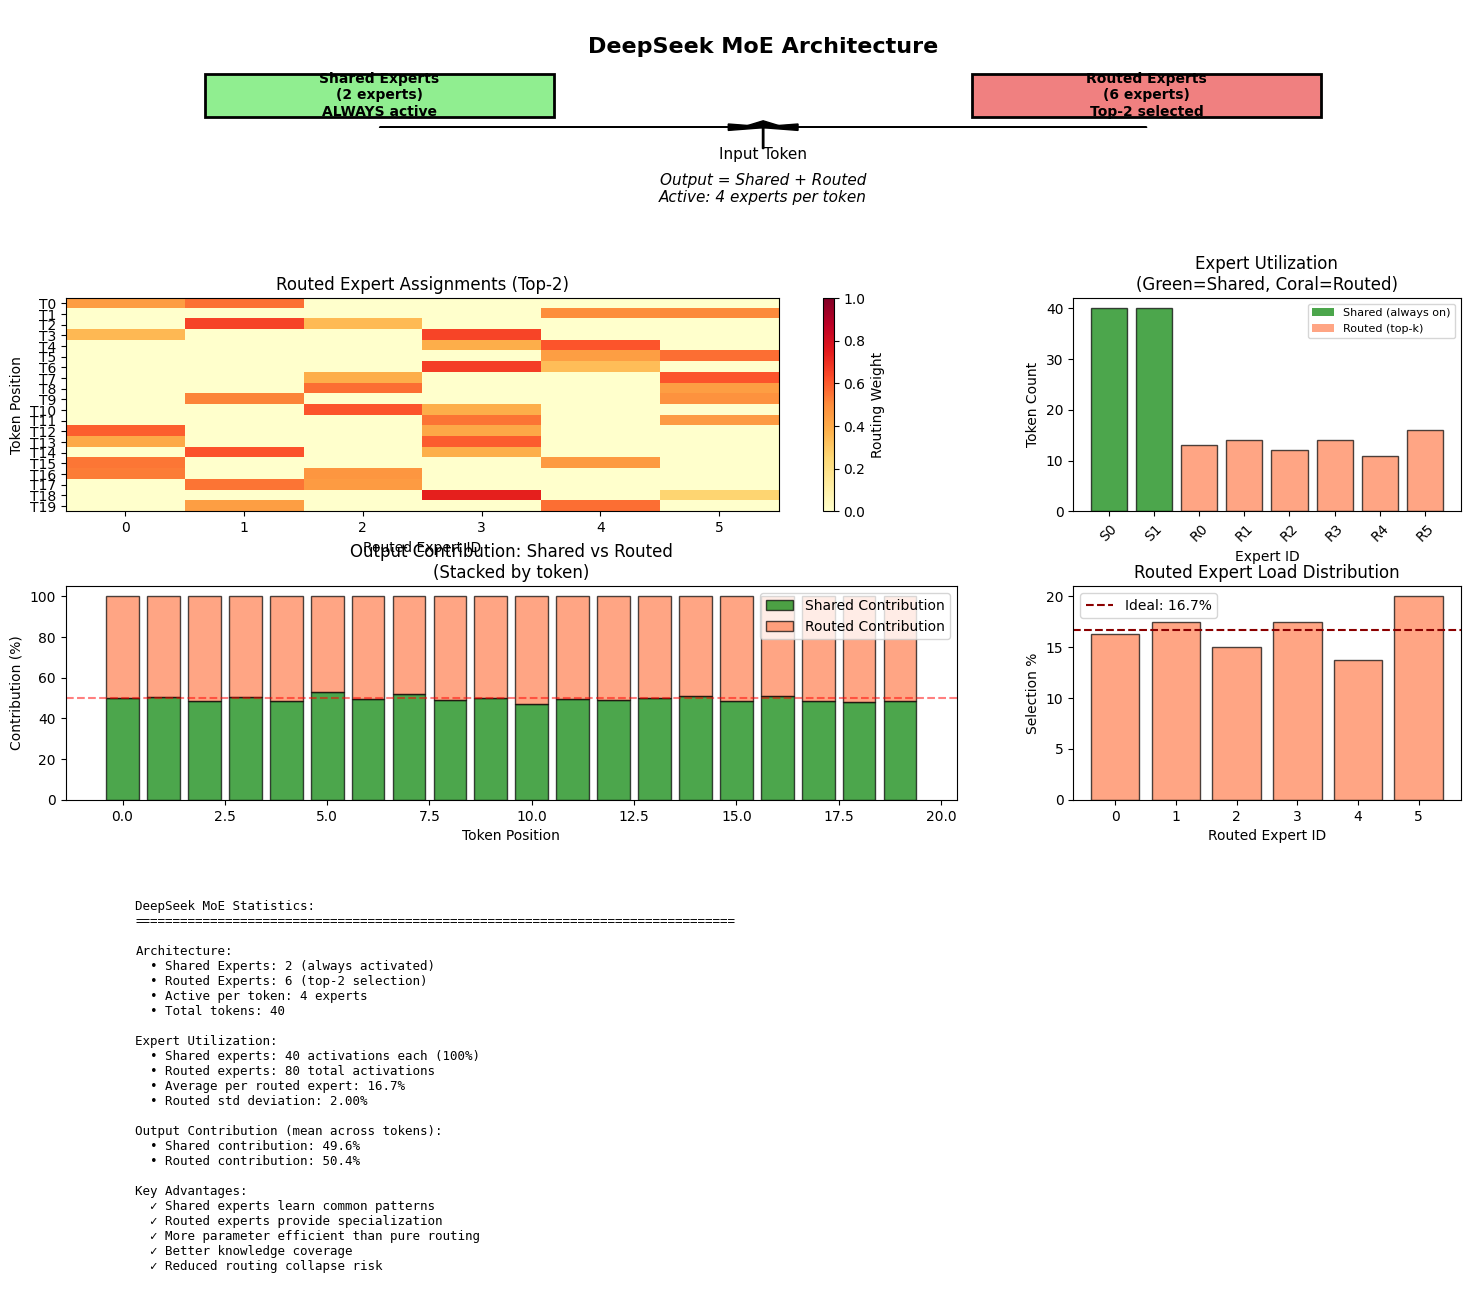


📊 DeepSeek MoE Detailed Statistics:
Architecture Summary:
  Total experts: 8
  - Shared (always on): 2
  - Routed (top-2): 6
  Active per token: 4
  Efficiency: 50.0% experts active

Shared Expert Usage:
  Shared 0:  40 tokens (100%)
  Shared 1:  40 tokens (100%)

Routed Expert Usage:
  Routed 0: █████                 16.2% ( 13 selections)
  Routed 1: █████                 17.5% ( 14 selections)
  Routed 2: █████                 15.0% ( 12 selections)
  Routed 3: █████                 17.5% ( 14 selections)
  Routed 4: ████                  13.8% ( 11 selections)
  Routed 5: ██████                20.0% ( 16 selections)

Contribution Analysis:
  Shared avg: 49.6% ± 1.3%
  Routed avg: 50.4% ± 1.3%


In [7]:
def visualize_deepseek_moe(model, x, token_labels=None):
    """
    Visualize DeepSeek's hybrid shared+routed expert architecture
    """
    moe_layer = model.moe if hasattr(model, 'moe') else model
    
    with torch.no_grad():
        _, router_info = moe_layer(x, return_router_info=True)
    
    batch_size, seq_len, _ = x.shape
    num_tokens = batch_size * seq_len
    
    num_shared = moe_layer.num_shared_experts
    num_routed = moe_layer.num_routed_experts
    top_k = moe_layer.top_k
    
    # Extract info
    top_k_indices = router_info['top_k_indices']
    top_k_weights = router_info['top_k_weights']
    shared_counts = router_info['shared_expert_counts']
    routed_counts = router_info['routed_expert_counts']
    
    # Create visualization
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)
    
    # Plot 1: Architecture diagram
    ax1 = fig.add_subplot(gs[0, :])
    ax1.text(0.5, 0.8, "DeepSeek MoE Architecture", 
             ha='center', fontsize=16, weight='bold', transform=ax1.transAxes)
    
    # Draw boxes
    ax1.add_patch(plt.Rectangle((0.1, 0.5), 0.25, 0.2, 
                                fill=True, color='lightgreen', ec='black', lw=2))
    ax1.text(0.225, 0.6, f'Shared Experts\n({num_shared} experts)\nALWAYS active', 
             ha='center', va='center', fontsize=10, weight='bold')
    
    ax1.add_patch(plt.Rectangle((0.65, 0.5), 0.25, 0.2, 
                                fill=True, color='lightcoral', ec='black', lw=2))
    ax1.text(0.775, 0.6, f'Routed Experts\n({num_routed} experts)\nTop-{top_k} selected', 
             ha='center', va='center', fontsize=10, weight='bold')
    
    # Arrows
    ax1.arrow(0.5, 0.35, 0, 0.1, head_width=0.03, head_length=0.03, fc='black')
    ax1.text(0.5, 0.3, 'Input Token', ha='center', fontsize=11)
    
    ax1.arrow(0.225, 0.45, 0.25, 0, head_width=0.03, head_length=0.03, fc='black')
    ax1.arrow(0.775, 0.45, -0.25, 0, head_width=0.03, head_length=0.03, fc='black')
    
    ax1.text(0.5, 0.1, f'Output = Shared + Routed\n'
                       f'Active: {num_shared + top_k} experts per token',
             ha='center', fontsize=11, style='italic')
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')
    
    # Plot 2: Routed expert assignment matrix
    ax2 = fig.add_subplot(gs[1, :2])
    
    assignment_matrix = np.zeros((seq_len, num_routed))
    for t in range(seq_len):
        for k in range(top_k):
            expert_idx = top_k_indices[0, t, k].item()
            weight = top_k_weights[0, t, k].item()
            assignment_matrix[t, expert_idx] = weight
    
    im2 = ax2.imshow(assignment_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    ax2.set_xlabel('Routed Expert ID')
    ax2.set_ylabel('Token Position')
    ax2.set_title(f'Routed Expert Assignments (Top-{top_k})')
    plt.colorbar(im2, ax=ax2, label='Routing Weight')
    
    if token_labels:
        ax2.set_yticks(range(len(token_labels)))
        ax2.set_yticklabels(token_labels)
    
    # Plot 3: Expert utilization comparison
    ax3 = fig.add_subplot(gs[1, 2])
    
    # Combine shared and routed for visualization
    all_expert_counts = torch.cat([shared_counts, routed_counts]).cpu().numpy()
    all_expert_labels = ([f'S{i}' for i in range(num_shared)] + 
                         [f'R{i}' for i in range(num_routed)])
    
    colors = ['green'] * num_shared + ['coral'] * num_routed
    bars = ax3.bar(range(len(all_expert_counts)), all_expert_counts, 
                   color=colors, alpha=0.7, edgecolor='black')
    
    ax3.set_xlabel('Expert ID')
    ax3.set_ylabel('Token Count')
    ax3.set_title('Expert Utilization\n(Green=Shared, Coral=Routed)')
    ax3.set_xticks(range(len(all_expert_labels)))
    ax3.set_xticklabels(all_expert_labels, rotation=45)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='Shared (always on)'),
        Patch(facecolor='coral', alpha=0.7, label='Routed (top-k)')
    ]
    ax3.legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    # Plot 4: Output contribution analysis
    ax4 = fig.add_subplot(gs[2, :2])
    
    shared_out = router_info['shared_output'][0, :, :].cpu()  # [seq_len, d_model]
    routed_out = router_info['routed_output'][0, :, :].cpu()
    
    shared_norm = torch.norm(shared_out, dim=1).numpy()
    routed_norm = torch.norm(routed_out, dim=1).numpy()
    total_norm = shared_norm + routed_norm
    
    shared_pct = shared_norm / total_norm * 100
    routed_pct = routed_norm / total_norm * 100
    
    x_pos = np.arange(seq_len)
    ax4.bar(x_pos, shared_pct, label='Shared Contribution', 
            color='green', alpha=0.7, edgecolor='black')
    ax4.bar(x_pos, routed_pct, bottom=shared_pct, label='Routed Contribution',
            color='coral', alpha=0.7, edgecolor='black')
    
    ax4.set_xlabel('Token Position')
    ax4.set_ylabel('Contribution (%)')
    ax4.set_title('Output Contribution: Shared vs Routed\n(Stacked by token)')
    ax4.legend()
    ax4.axhline(y=50, color='red', linestyle='--', alpha=0.5)
    
    # Plot 5: Routed expert load distribution
    ax5 = fig.add_subplot(gs[2, 2])
    
    routed_counts_np = routed_counts.cpu().numpy()
    total_routed = routed_counts_np.sum()
    routed_pcts = routed_counts_np / total_routed * 100
    
    bars = ax5.bar(range(num_routed), routed_pcts, color='coral', 
                   alpha=0.7, edgecolor='black')
    ax5.axhline(y=100/num_routed, color='darkred', linestyle='--',
                label=f'Ideal: {100/num_routed:.1f}%')
    ax5.set_xlabel('Routed Expert ID')
    ax5.set_ylabel('Selection %')
    ax5.set_title('Routed Expert Load Distribution')
    ax5.legend()
    
    # Color by utilization
    ideal = 100 / num_routed
    for i, (bar, pct) in enumerate(zip(bars, routed_pcts)):
        if pct < ideal * 0.5:
            bar.set_color('red')
        elif pct > ideal * 1.5:
            bar.set_color('orange')
    
    # Plot 6: Statistics
    ax6 = fig.add_subplot(gs[3, :])
    
    stats_text = f"""
DeepSeek MoE Statistics:
{'='*80}

Architecture:
  • Shared Experts: {num_shared} (always activated)
  • Routed Experts: {num_routed} (top-{top_k} selection)
  • Active per token: {num_shared + top_k} experts
  • Total tokens: {num_tokens}

Expert Utilization:
  • Shared experts: {num_tokens} activations each (100%)
  • Routed experts: {total_routed:.0f} total activations
  • Average per routed expert: {routed_pcts.mean():.1f}%
  • Routed std deviation: {routed_pcts.std():.2f}%

Output Contribution (mean across tokens):
  • Shared contribution: {shared_pct.mean():.1f}%
  • Routed contribution: {routed_pct.mean():.1f}%

Key Advantages:
  ✓ Shared experts learn common patterns
  ✓ Routed experts provide specialization
  ✓ More parameter efficient than pure routing
  ✓ Better knowledge coverage
  ✓ Reduced routing collapse risk
    """
    
    ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, 
             fontsize=9, verticalalignment='top', family='monospace')
    ax6.axis('off')
    
    plt.show()
    
    # Print detailed statistics
    print(f"\n📊 DeepSeek MoE Detailed Statistics:")
    print(f"{'='*70}")
    print(f"Architecture Summary:")
    print(f"  Total experts: {num_shared + num_routed}")
    print(f"  - Shared (always on): {num_shared}")
    print(f"  - Routed (top-{top_k}): {num_routed}")
    print(f"  Active per token: {num_shared + top_k}")
    print(f"  Efficiency: {(num_shared + top_k)/(num_shared + num_routed)*100:.1f}% experts active")
    
    print(f"\nShared Expert Usage:")
    for i in range(num_shared):
        count = shared_counts[i].item()
        print(f"  Shared {i}: {count:3.0f} tokens (100%)")
    
    print(f"\nRouted Expert Usage:")
    for i in range(num_routed):
        count = routed_counts[i].item()
        pct = count / total_routed * 100
        bar = '█' * int(pct / 3)
        print(f"  Routed {i}: {bar:<20} {pct:5.1f}% ({count:3.0f} selections)")
    
    print(f"\nContribution Analysis:")
    print(f"  Shared avg: {shared_pct.mean():.1f}% ± {shared_pct.std():.1f}%")
    print(f"  Routed avg: {routed_pct.mean():.1f}% ± {routed_pct.std():.1f}%")

# Test visualization
deepseek_moe = DeepSeekMoELayer(
    d_model=512,
    num_shared_experts=2,
    num_routed_experts=6,
    top_k=2
)
x = torch.randn(2, 20, 512)
token_labels = [f"T{i}" for i in range(20)]

visualize_deepseek_moe(deepseek_moe, x, token_labels)